# Clustering

### Imports

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Data Selection

In [173]:
df = pd.read_csv('../../data/01-modified-data/occupations_detailed_(employment_by_sex_and_wage).csv')

## drop unneeded column created from read_csv
df = df.iloc[:, 1:]

In [174]:
## reorder columns
df = df[['TOT_EMP', 'A_MEAN', 'Women (%)', 'Men (%)', 'Target', 'Target_Num', 'OCC_TITLE']]

## Feature Selection

In [175]:
X = df.iloc[:, 0:4]

### Normalization

In [176]:
X=0.1+(X-np.min(X,axis=0))/(np.max(X,axis=0)-np.min(X,axis=0))

### Numerical EDA

In [177]:
corr = X.corr()
print(corr)	

            TOT_EMP    A_MEAN  Women (%)   Men (%)
TOT_EMP    1.000000 -0.102376   0.071952 -0.071952
A_MEAN    -0.102376  1.000000  -0.201373  0.201373
Women (%)  0.071952 -0.201373   1.000000 -1.000000
Men (%)   -0.071952  0.201373  -1.000000  1.000000


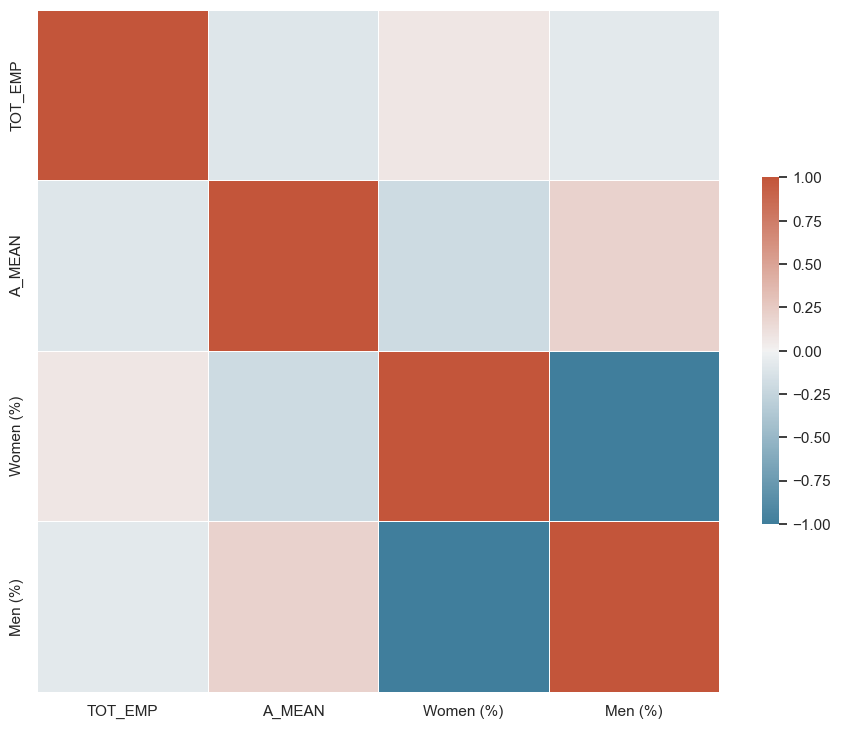

In [178]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))  # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) 	# Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

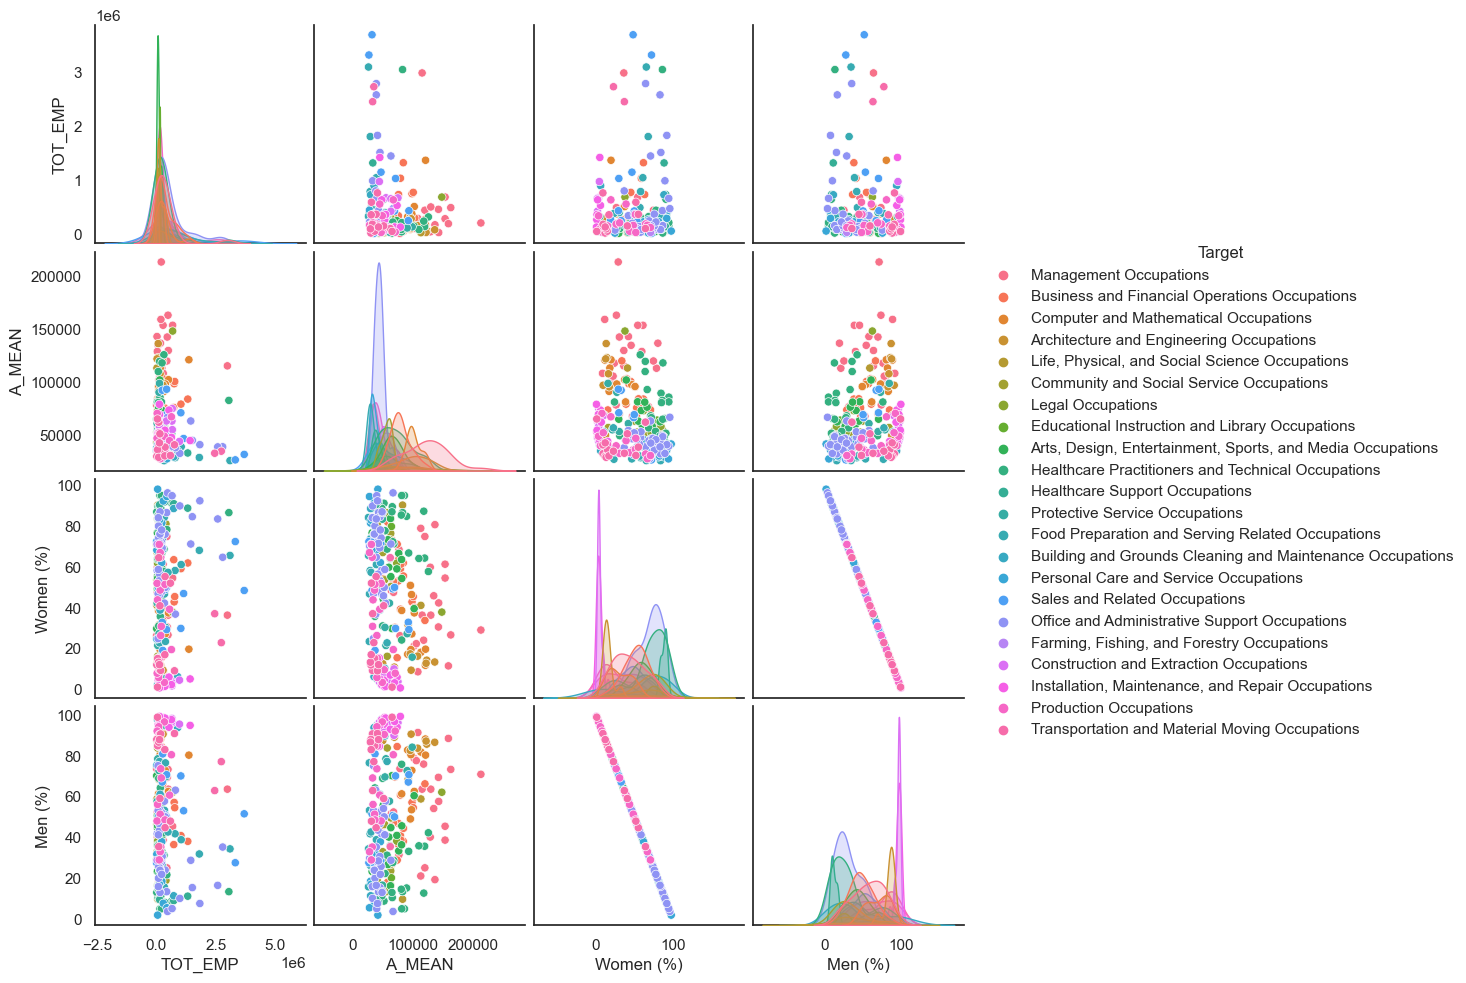

In [179]:
sns.pairplot(df.iloc[:,0:5], hue='Target')
plt.show()

In [180]:
X.drop(columns=['Men (%)'], inplace=True)

## Hyper-Parameter Tuning

In [181]:
X = np.ascontiguousarray(X)
NDIM = X.shape[1]

In [201]:
## helper functions
import sklearn.cluster

# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH) 
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):
    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    name = algo
    sil_max=-10
    for param in range(2,nmax+1):
        if(algo=="birch"):
            name = "Birch"
            model = sklearn.cluster.Birch(n_clusters=param).fit(X)
            labels=model.predict(X)

        if(algo=="ag"):
            name = "Agglomerative"
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param, linkage='ward').fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            name = "DBSCAN"
            param=0.5*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            name = "K-Means"
            model = sklearn.cluster.KMeans(n_clusters=param, random_state=1234).fit(X)
            labels=model.predict(X)
            
        if(algo=="ms"):
            name = "Mean Shift"
            model = sklearn.cluster.MeanShift().fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue 
        
        if(sil_scores[-1]>sil_max):
            opt_param=param
            sil_max=sil_scores[-1]
            opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.set_title("Silhouette Scores based on # of Clusters (%s)" % name)
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

In [183]:
def plot(x,opt_labels,title=''):
	if(NDIM==2):
		fig, ax = plt.subplots()
		sp=ax.scatter(x[:,0], x[:,1],c=opt_labels,marker=".", cmap="viridis")
		plt.colorbar(sp)

	if(NDIM==3):
		fig = plt.figure()
		ax = fig.add_subplot(projection='3d')
		sp=ax.scatter(x[:,0],x[:,1],x[:,2],c=opt_labels,marker=".", cmap="viridis")
		plt.colorbar(sp)

	#DO PCA TO VISUALIZE
	if(NDIM>3):
		from sklearn.decomposition import PCA
		pca = PCA(n_components=3)
		pca.fit(x)
		Y=pca.fit_transform(x)
		fig = plt.figure()
		ax = fig.add_subplot(projection='3d')
		sp=ax.scatter(Y[:,0],Y[:,1],Y[:,2],c=opt_labels,marker=".", cmap="viridis")
		plt.colorbar(sp)
	plt.title(title)
	plt.show()

### K-Means

OPTIMAL PARAMETER = 3


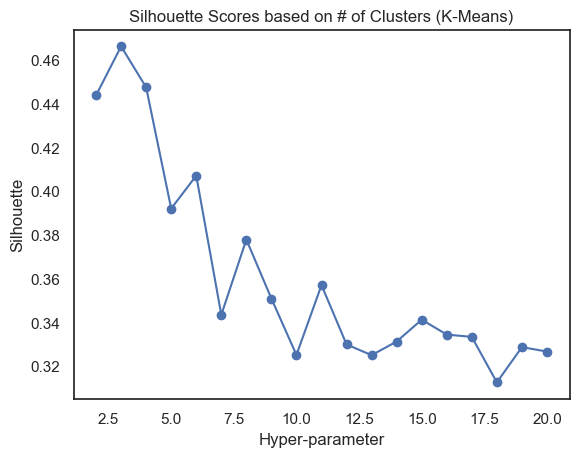

In [184]:
# KMEANS
opt_labels=maximize_silhouette(X,algo="kmeans",i_plot=True)

### Final Results

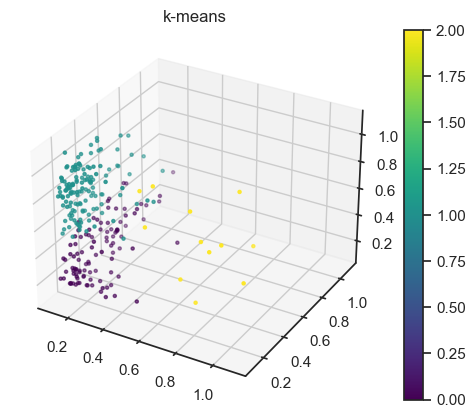

In [185]:
plot(X,opt_labels,"k-means")

### DBSCAN

Text(0, 0.5, 'Distance')

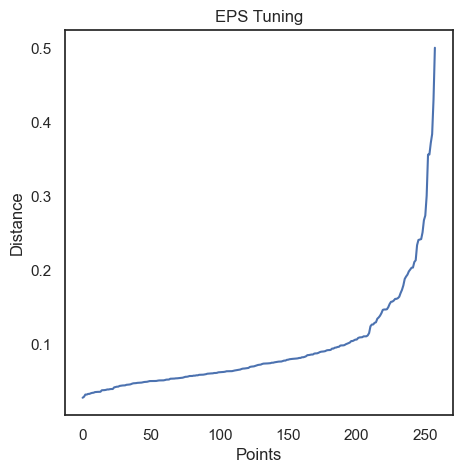

In [186]:
# Finding optimal EPS
## ref: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
model = sklearn.neighbors.NearestNeighbors()
model = model.fit(X)

distances, indices = model.kneighbors(X)
distances = np.sort(distances[:,4], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.title("EPS Tuning")
plt.xlabel("Points")
plt.ylabel("Distance")

0.14666469356034625


<Figure size 500x500 with 0 Axes>

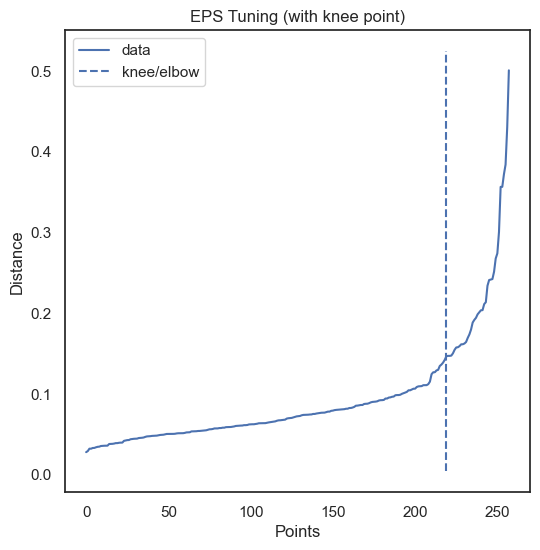

In [187]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.title("EPS Tuning (with knee point)")
plt.xlabel("Points")
plt.ylabel("Distance")

eps = distances[knee.knee]
print(eps)

In [188]:
# Finding optimal min_samples
## ref: https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r

import math
min_samples = round(math.log(df.shape[0]))

In [189]:
model = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
opt_labels=model.labels_
sklearn.metrics.silhouette_score(X,opt_labels)

0.34011471243009594

### Final Results

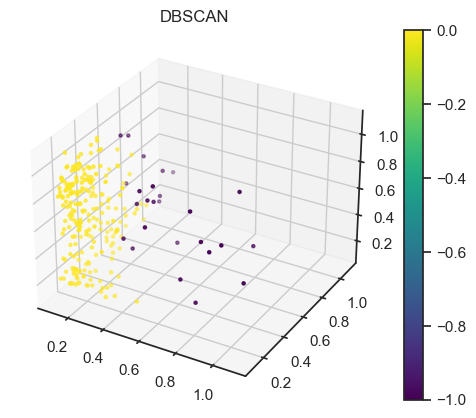

In [190]:
plot(X,opt_labels,'DBSCAN')

### Hierarchical (Agglomerative)

OPTIMAL PARAMETER = 4


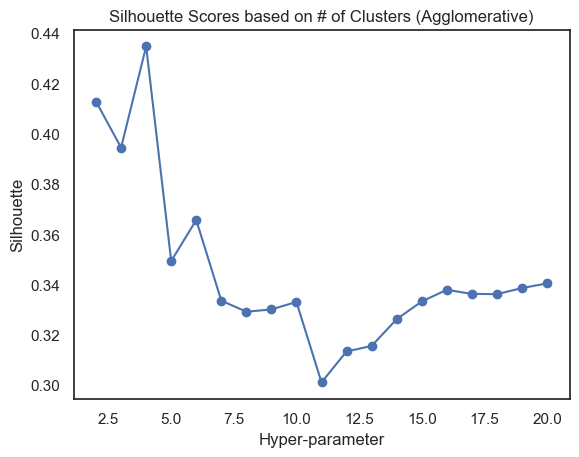

In [202]:
# AGGLOMERATIVE CLUSTERING
opt_labels=maximize_silhouette(X,algo="ag",i_plot=True)

### Final Results

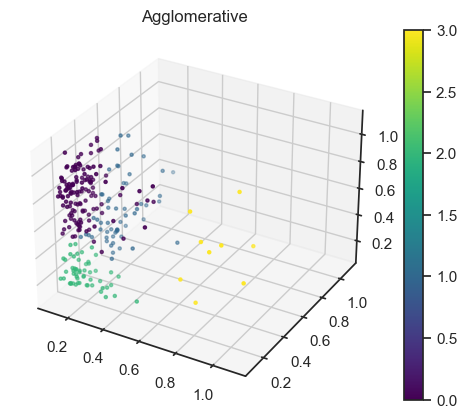

In [203]:
plot(X,opt_labels,'Agglomerative')

([], [])

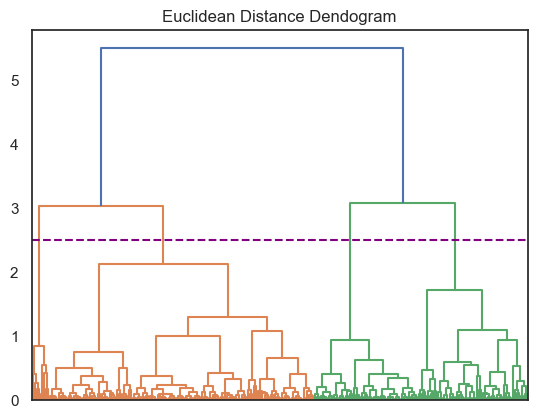

In [213]:
from scipy.cluster.hierarchy import dendrogram, linkage

link = linkage(X, method='ward')
dend = dendrogram(link)
plt.axhline(c='purple',linestyle='--', y=2.5) 
plt.title("Euclidean Distance Dendogram")
plt.xticks([])